In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


your workflow could be clearer

You have a little bit data leakage before you split

and you are asked to evaluate EACH model with multiple metrics


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline

#Data Description:
Dataframe is 1599 records of physico-chemical properties of red wine and their rated wine quality. There are 11 features and a target quality rating which will be treated as a regression problem. We seek to be able to predict wine quality through physico-chemical properties that can be used to mass test wine in place of wine tastings with limited throughput.

In [18]:
#Data Description: Target is wine quality which we will treat as a regression problem.
df0 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Files and Assignments/winequality-red.csv', sep=';')
pd.set_option('display.width',250)
pd.set_option('display.max_columns',15)
pd.set_option('display.min_rows', 50)
print('Data Shape: ', df0.shape)
print(df0.head(2))
print(df0.describe())
print(df0.info())

Data Shape:  (1599, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  alcohol  quality
0            7.4              0.70          0.0             1.9      0.076                 11.0                  34.0   0.9978  3.51       0.56      9.4        5
1            7.8              0.88          0.0             2.6      0.098                 25.0                  67.0   0.9968  3.20       0.68      9.8        5
       fixed acidity  volatile acidity  citric acid  residual sugar    chlorides  free sulfur dioxide  total sulfur dioxide      density           pH    sulphates      alcohol      quality
count    1599.000000       1599.000000  1599.000000     1599.000000  1599.000000          1599.000000           1599.000000  1599.000000  1599.000000  1599.000000  1599.000000  1599.000000
mean        8.319637          0.527821     0.270976        2.538806     0.087467            15.874922           

#Data Cleansing

In [4]:
print(df0.info())
print('\n\n Number of Duplicated Rows: ',df0.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


 Number of Duplicated Rows:  240


In [5]:
df_noquality = df0.drop(columns='quality')
print(df_noquality.shape)
print('Number of Duplicated Bottles: ', df_noquality.duplicated().sum())

(1599, 11)
Number of Duplicated Bottles:  240


In [6]:
df0 = df0.drop_duplicates()
print(df0.shape)

(1359, 12)


In [7]:
#Address Missing Values
df0.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [8]:
#For Loop to find outliers and inconsistent categories
counter = len(df0.loc[1,:])  
for x in range(counter):
  if df0.iloc[:,x].dtypes == 'int64':
    print('\n\n', df0.iloc[:,x].head(0))
    print('Min =', df0.iloc[:,x].min())
    print('Max =', df0.iloc[:,x].max())
    print('Mean =', df0.iloc[:,x].mean())
  if df0.iloc[:,x].dtypes == 'float64':
    print('\n\n', df0.iloc[:,x].head(0))
    print('Min =', df0.iloc[:,x].min())
    print('Max =', df0.iloc[:,x].max())
    print('Mean =', df0.iloc[:,x].mean())
  elif df0.iloc[:,x].dtypes == 'object':
    print('\n\n', df0.iloc[:,x].head(0))
    print('Categories: ', df0.iloc[:,x].value_counts())



 Series([], Name: fixed acidity, dtype: float64)
Min = 4.6
Max = 15.9
Mean = 8.310596026490087


 Series([], Name: volatile acidity, dtype: float64)
Min = 0.12
Max = 1.58
Mean = 0.5294775570272258


 Series([], Name: citric acid, dtype: float64)
Min = 0.0
Max = 1.0
Mean = 0.27233259749815975


 Series([], Name: residual sugar, dtype: float64)
Min = 0.9
Max = 15.5
Mean = 2.523399558498897


 Series([], Name: chlorides, dtype: float64)
Min = 0.012
Max = 0.611
Mean = 0.0881236203090504


 Series([], Name: free sulfur dioxide, dtype: float64)
Min = 1.0
Max = 72.0
Mean = 15.893303899926417


 Series([], Name: total sulfur dioxide, dtype: float64)
Min = 6.0
Max = 289.0
Mean = 46.82597498160412


 Series([], Name: density, dtype: float64)
Min = 0.99007
Max = 1.00369
Mean = 0.9967089477557026


 Series([], Name: pH, dtype: float64)
Min = 2.74
Max = 4.01
Mean = 3.309786607799856


 Series([], Name: sulphates, dtype: float64)
Min = 0.33
Max = 2.0
Mean = 0.6587049300956593


 Series([], Name: a

In [9]:
#Deeper look at potential outliers
temp1 = df0['volatile acidity'].sort_values(ascending=False)
temp2 = df0['residual sugar'].sort_values(ascending=False)
temp3 = df0['chlorides'].sort_values(ascending=False)
temp4 = df0['free sulfur dioxide'].sort_values(ascending=False)
temp5 = df0['total sulfur dioxide'].sort_values(ascending=False)
print(temp1.head())
print(temp2.head())
print(temp3.head())
print(temp4.head())
print(temp5.head())


1299    1.580
126     1.330
127     1.330
672     1.240
690     1.185
Name: volatile acidity, dtype: float64
480     15.5
1434    15.4
1574    13.9
1474    13.8
1244    13.4
Name: residual sugar, dtype: float64
258    0.611
151    0.610
106    0.467
81     0.464
692    0.422
Name: chlorides, dtype: float64
1244    72.0
396     68.0
1558    66.0
1131    57.0
1434    55.0
Name: free sulfur dioxide, dtype: float64
1081    289.0
1079    278.0
354     165.0
1244    160.0
651     155.0
Name: total sulfur dioxide, dtype: float64


#Exploratory Visualizations
Using a histogram we see the distribution of the features and target vector. Most wines were rated mid to low high.
Using a heatmap we can see the correlation between the elements of our dataframe. We see a moderate correlation between quality and alcohol content.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e31957c90>,
      dtype=object)

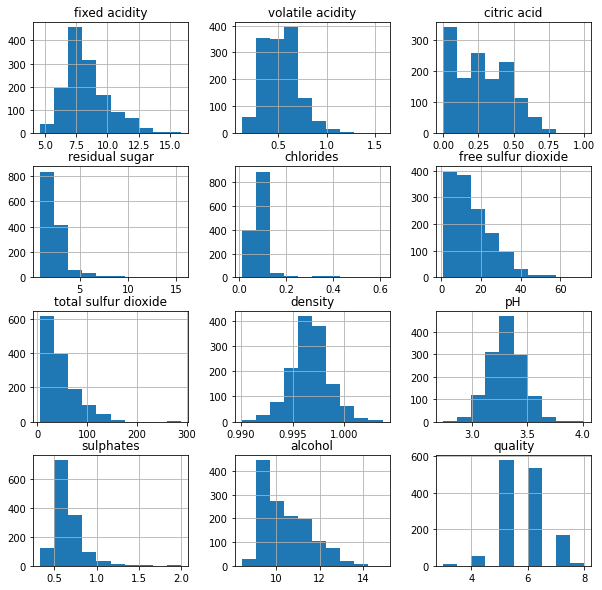

In [10]:
df0.hist(figsize=(10,10))

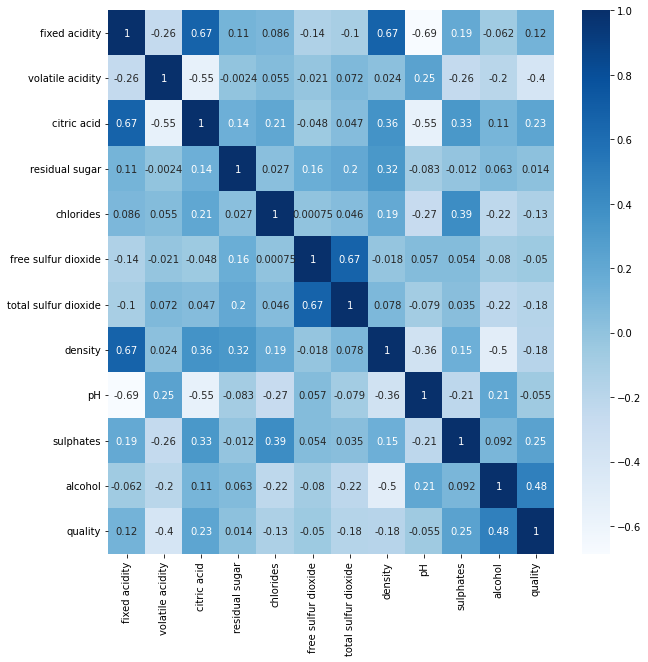

In [14]:
corr = df0.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap = 'Blues', annot=True)


#Data Preprocessing and Pipelines

In [8]:
#Train Test Split
X = df0.drop(columns=['quality'])
y = df0['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

In [9]:
#Turn alcohol content in to binary categories as there is a bit of correlation towards quality and alcohol content

#Do this after the split and apply the median to the training data

alc_train_median= X_train['alcohol'].median()
X_train['alcohol'] = X_train['alcohol'].apply(lambda x: 'high' if x >= alc_train_median else 'low')
X_train['alcohol'].value_counts()

alc_test_median= X_test['alcohol'].median()
X_test['alcohol'] = X_test['alcohol'].apply(lambda x: 'high' if x >= alc_test_median else 'low')
X_test['alcohol'].value_counts()

high    177
low     163
Name: alcohol, dtype: int64

In [10]:


cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')
#I chose an ordinal encoder to encode the binary high/low alcohol content
ord = OrdinalEncoder()
scaler = StandardScaler()
num_tuple = (scaler, num_selector)
cat_tuple = (ord, cat_selector) 
preprocess_transformer = make_column_transformer(num_tuple, cat_tuple)


#Model Selection:
*   XGBoost
*   RandomForest
*   Keras

These models were selected after previewing their performance in this section. Having scored the highest, we will later determine whether we are able to improve on their scores through hyperparameter tuning.

This was treated as a classification problem since there were finite categories of quality rankings.

In [11]:
#Load evaluation libraries and formula
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def evaluateregression(y_test, y_pred):
  """takes two arrays, true labels and predicted labels, and prints
  MAE, MSE, RMSE, and R2 metrics"""
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  rmse = np.sqrt(mse)
  print(f'MAE {mae}\n MSE {mse}\n R^2 {r2}\n RMSE {rmse}')

In [12]:
#Load regression models

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

def RegressionBoost(X_train, X_test, y_train, y_test):
  gradientboost = GradientBoostingRegressor()
  gbr = make_pipeline(preprocess_transformer, gradientboost)    #instantiate model
  gbr.fit(X_train, y_train)      #Can create pipeline with preprocessors before this line and name the pipeline as gbr
  gbrtrainpred = gbr.predict(X_train)
  gbrtestpred = gbr.predict(X_test)
  print('---'*5, 'Created gbr model', '---'*5)
  print('Train Metrics')
  evaluateregression(y_train, gbrtrainpred)  
  print('Test Metrics')  
  evaluateregression(y_test, gbrtestpred)

  lgbmboost = LGBMRegressor()
  lgbm = make_pipeline(preprocess_transformer, lgbmboost)
  lgbm.fit(X_train, y_train)
  lgbmtrainpred = lgbm.predict(X_train)
  lgbmtestpred = lgbm.predict(X_test)
  print('---'*5, 'Created lgbm model', '---'*5)
  print('Train Metrics')
  evaluateregression(y_train, lgbmtrainpred)  
  print('Test Metrics')  
  evaluateregression(y_test, lgbmtestpred)

  xgbboost = XGBRegressor()
  xgb = make_pipeline(preprocess_transformer, xgbboost)
  xgb.fit(X_train, y_train)
  xgbtrainpred = xgb.predict(X_train)
  xgbtestpred = xgb.predict(X_test)
  print('---'*5, 'Created xgb model', '---'*5)
  print('Train Metrics')
  evaluateregression(y_train, xgbtrainpred)  
  print('Test Metrics')  
  evaluateregression(y_test, xgbtestpred)

  randomforest = RandomForestRegressor(random_state = 42)
  rf = make_pipeline(preprocess_transformer, randomforest)
  rf.fit(X_train, y_train)
  rftrainpred = rf.predict(X_train)
  rftestpred = rf.predict(X_test)
  print('---'*5, 'Created rf model', '---'*5)
  print('Train Metrics')
  evaluateregression(y_train, rftrainpred)  
  print('Test Metrics')  
  evaluateregression(y_test, rftestpred)

  linregression = LinearRegression()
  linreg = make_pipeline(preprocess_transformer, linregression)
  linreg.fit(X_train, y_train)
  linregtrainpred = linreg.predict(X_train)
  linregtestpred = linreg.predict(X_test)
  print('---'*5, 'Created linreg model', '---'*5)
  print('Train Metrics')
  evaluateregression(y_train, linregtrainpred)  
  print('Test Metrics')  
  evaluateregression(y_test, linregtestpred)



In [31]:
#Test multiple models to find the regression model that works best
RegressionBoost(X_train, X_test, y_train, y_test)

--------------- Created gbr model ---------------
Train Metrics
MAE 0.38487114800821354
 MSE 0.24131516866703454
 R^2 0.6431296129076185
 RMSE 0.49123840308656097
Test Metrics
MAE 0.5108612120350703
 MSE 0.43636615582664584
 R^2 0.3606518762777696
 RMSE 0.6605801660863319
--------------- Created lgbm model ---------------
Train Metrics
MAE 0.17800441680102372
 MSE 0.05497126623905211
 R^2 0.9187054126350541
 RMSE 0.23445951940378132
Test Metrics
MAE 0.5197556841232194
 MSE 0.4567571918424078
 R^2 0.33077565777788887
 RMSE 0.6758381402691089
[00:36:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------- Created xgb model ---------------
Train Metrics
MAE 0.3857950562934763
 MSE 0.2464371991945289
 R^2 0.6355548672870146
 RMSE 0.49642441438201734
Test Metrics
MAE 0.5155196358175839
 MSE 0.4372045924928617
 R^2 0.3594234287864889
 RMSE 0.6612144829727051
--------------- Created rf model ---------------
Train M

#RandomForest Model

In [22]:
#Improve on RandomForest Model using GridSearchCV
randomforest = RandomForestRegressor(random_state = 42)
rf = make_pipeline(preprocess_transformer, randomforest)
modelpipe = rf
modelpipe.get_params()

{'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6e2b8bf3d0>),
                                 ('ordinalencoder', OrdinalEncoder(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6e2b8bf410>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__ordinalencoder': OrdinalEncoder(),
 'columntransformer__ordinalencoder__categories': 'auto',
 'columntransformer__ordinalencoder__dtype': numpy.float64,
 'columntransformer__ordinalencoder__handle_unknown': 'error',
 'columntransformer__ordinalencoder__unknown_value': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__standardscaler': StandardScaler(),
 'columntransformer__standardscaler__copy': True,
 'columntransformer__standardscaler__with_mean': True,
 'columntransforme

In [26]:
#Tune Hyperparameters
param_grid = { 'randomforestregressor__n_estimators': [500, 1000], 'randomforestregressor__max_depth': [2,4,8,16,32,64], 'randomforestregressor__criterion': 'squared_error'}
model_grid = GridSearchCV(modelpipe, param_grid)
model_grid.fit(X_train, y_train)
print('Best Hyperparameter Settings: ', model_grid.best_params_)
best_model = model_grid.best_estimator_

Best Hyperparameter Settings:  {'randomforestregressor__max_depth': 8, 'randomforestregressor__n_estimators': 1000}


In [27]:
#Fit model to training data and run evaluation metrics
best_model.fit(X_train, y_train)
best_y_testpred = best_model.predict(X_test)
best_y_trainpred = best_model.predict(X_train)
evaluateregression(y_test, best_y_testpred)


MAE 0.5101300220084106
 MSE 0.4390718132744004
 R^2 0.35668764351232984
 RMSE 0.6626249416331991


#GradientBoost Model

In [32]:
#Create and hyperparameter tune XGB Boost model
xgbboost = XGBRegressor()
xgb = make_pipeline(preprocess_transformer, xgbboost)
modelpipe = xgb
modelpipe.get_params()

{'columntransformer': ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6e2b8bf3d0>),
                                 ('ordinalencoder', OrdinalEncoder(),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6e2b8bf410>)]),
 'columntransformer__n_jobs': None,
 'columntransformer__ordinalencoder': OrdinalEncoder(),
 'columntransformer__ordinalencoder__categories': 'auto',
 'columntransformer__ordinalencoder__dtype': numpy.float64,
 'columntransformer__ordinalencoder__handle_unknown': 'error',
 'columntransformer__ordinalencoder__unknown_value': None,
 'columntransformer__remainder': 'drop',
 'columntransformer__sparse_threshold': 0.3,
 'columntransformer__standardscaler': StandardScaler(),
 'columntransformer__standardscaler__copy': True,
 'columntransformer__standardscaler__with_mean': True,
 'columntransforme

In [38]:
#Tune Hyperparameters
param_grid = { 'xgbregressor__n_estimators': [100, 500, 1000], 'xgbregressor__max_depth': [2,4,8], 'xgbregressor__learning_rate': [0.01,0.1,1,], 'xgbregressor__objective': ['reg:squarederror']}
xgbmodel_grid = GridSearchCV(modelpipe, param_grid)
xgbmodel_grid.fit(X_train, y_train)
print('Best Hyperparameter Settings: ', xgbmodel_grid.best_params_)
xgbbest_model = xgbmodel_grid.best_estimator_

Best Hyperparameter Settings:  {'xgbregressor__learning_rate': 0.1, 'xgbregressor__max_depth': 2, 'xgbregressor__n_estimators': 100, 'xgbregressor__objective': 'reg:squarederror'}


In [39]:
xgbbest_model.fit(X_train, y_train)
xgbbest_y_testpred = xgbbest_model.predict(X_test)
xgbbest_y_trainpred = xgbbest_model.predict(X_train)
evaluateregression(y_test, best_y_testpred)


MAE 0.5101300220084106
 MSE 0.4390718132744004
 R^2 0.35668764351232984
 RMSE 0.6626249416331991


#Keras Sequential Model

Epoch 1/100
32/32 [==============================] - 1s 7ms/step - loss: 35.3977 - val_loss: 31.9135
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 30.9130 - val_loss: 28.1376
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 26.8629 - val_loss: 24.8070
Epoch 4/100
32/32 [==============================] - 0s 2ms/step - loss: 23.1413 - val_loss: 21.4694
Epoch 5/100
32/32 [==============================] - 0s 3ms/step - loss: 19.9609 - val_loss: 17.8554
Epoch 6/100
32/32 [==============================] - 0s 3ms/step - loss: 16.5509 - val_loss: 14.2691
Epoch 7/100
32/32 [==============================] - 0s 3ms/step - loss: 13.7100 - val_loss: 11.1200
Epoch 8/100
32/32 [==============================] - 0s 3ms/step - loss: 11.7949 - val_loss: 8.6815
Epoch 9/100
32/32 [==============================] - 0s 3ms/step - loss: 10.1275 - val_loss: 6.8062
Epoch 10/100
32/32 [==============================] - 0s 2ms/step - loss: 8.8022 - val_loss: 

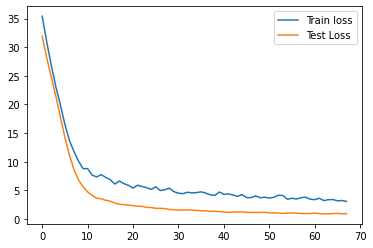

In [16]:
#Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

X_train = preprocess_transformer.fit_transform(X_train)
X_test = preprocess_transformer.transform(X_test)
input_shape = X_train.shape[1]
input_shape
model = Sequential()


# First hidden layer
model.add(Dense(12, input_dim = input_shape, activation = 'relu'))
model.add(Dropout(0.2))    #Dropout 20% of previous layer
model.add(Dense(6, activation = 'relu'))
model.add(Dropout(0.2))   #Dropout 20% of previous layer
model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mse', optimizer = 'adam')
early_stopping = EarlyStopping(patience = 5) 
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=100, callbacks =[early_stopping])

# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();




In [17]:
#Evaluate Sequential model
keras_y_testpred = model.predict (X_test)
evaluateregression(y_test, keras_y_testpred)

MAE 0.8013064230189604
 MSE 0.9528470255057638
 R^2 -0.39607746800930665
 RMSE 0.9761388351590996


#Conclusion: Both RandomForest and XG Boost models achieve a 0.510 MAE and 0.439 MSE. Keras Sequential model did not perform so well here.